# Advanced street network plotting with OSMnx

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [4]:
import matplotlib.pyplot as plt
import osmnx as ox

%matplotlib inline
ox.__version__

'1.7.1'

In [2]:
place = "pattaya,chonburi"
G = ox.graph_from_place(place, network_type="drive")

## Color helper functions

You can use the plot module to get colors for plotting.

In [3]:
# get n evenly-spaced colors from some matplotlib colormap
ox.plot.get_colors(n=5, cmap="plasma", return_hex=True)

['#0d0887', '#7e03a8', '#cc4778', '#f89540', '#f0f921']

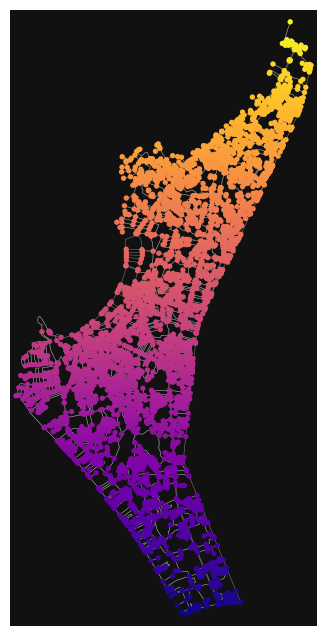

In [4]:
# get node colors by linearly mapping an attribute's values to a colormap
nc = ox.plot.get_node_colors_by_attr(G, attr="y", cmap="plasma")
fig, ax = ox.plot_graph(G, node_color=nc, edge_linewidth=0.3)

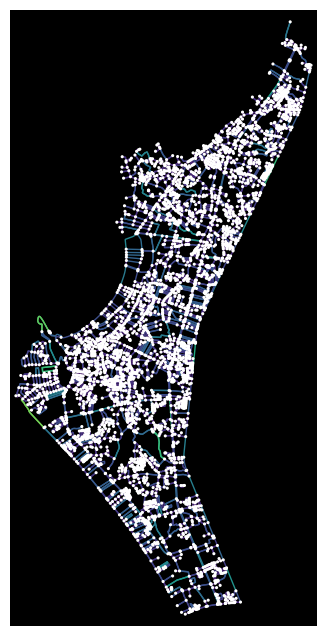

In [5]:
# when num_bins is not None, bin the nodes/edges then assign one color to each bin
# also set equal_size=True for equal-sized quantiles (requires unique bin edges!)
ec = ox.plot.get_edge_colors_by_attr(G, attr="length", num_bins=5)

# otherwise, when num_bins is None (default), linearly map one color to each node/edge by value
ec = ox.plot.get_edge_colors_by_attr(G, attr="length")

# plot the graph with colored edges
fig, ax = ox.plot_graph(G, node_size=5, edge_color=ec, bgcolor="k")

## Other plotting options

See the [documentation](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.plot.plot_graph) for full details.

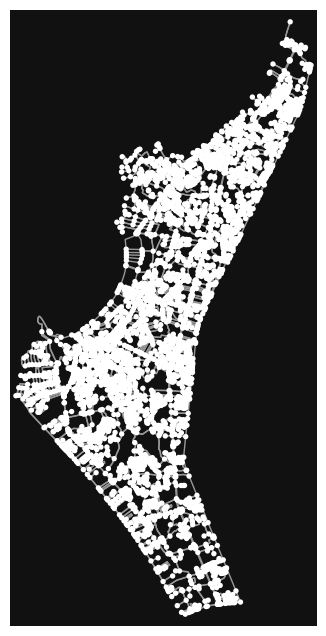

In [6]:
fig, ax = ox.plot_graph(
    G,
    ax=None,  # optionally draw on pre-existing axis
    figsize=(8, 8),  # figure size to create if ax is None
    bgcolor="#111111",  # background color of the plot
    node_color="w",  # color of the nodes
    node_size=15,  # size of the nodes: if 0, skip plotting them
    node_alpha=None,  # opacity of the nodes
    node_edgecolor="none",  # color of the nodes' markers' borders
    node_zorder=1,  # zorder to plot nodes: edges are always 1
    edge_color="#999999",  # color of the edges
    edge_linewidth=1,  # width of the edges: if 0, skip plotting them
    edge_alpha=None,  # opacity of the edges
    show=True,  # if True, call pyplot.show() to show the figure
    close=False,  # if True, call pyplot.close() to close the figure
    save=False,  # if True, save figure to disk at filepath
    filepath=None,  # if save is True, the path to the file
    dpi=300,  # if save is True, the resolution of saved file
    bbox=None,  # bounding box to constrain plot
)

Use bbox to constrain the plot (i.e., "zoom") to some precise section of the graph.

For example, perhaps we consolidated nearby intersections to clean-up node clusters and want to inspect our results:

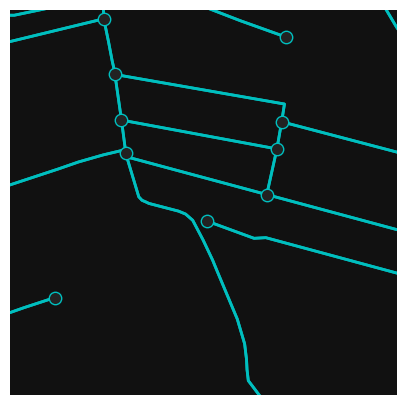

In [7]:
Gc = ox.consolidate_intersections(ox.project_graph(G), dead_ends=True)
c = ox.graph_to_gdfs(G, edges=False).unary_union.centroid
bbox = ox.utils_geo.bbox_from_point(point=(c.y, c.x), dist=200, project_utm=True)
fig, ax = ox.plot_graph(
    Gc,
    figsize=(5, 5),
    bbox=bbox,
    edge_linewidth=2,
    edge_color="c",
    node_size=80,
    node_color="#222222",
    node_edgecolor="c",
)

In [8]:
# or save a figure to disk instead of showing it
fig, ax = ox.plot_graph(G, filepath="./images/image.png", save=True, show=False, close=True)

## Plot routes

In [9]:
# impute missing edge speeds and calculate free-flow travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# calculate 3 shortest paths, minimizing travel time
w = "travel_time"
orig, dest = list(G)[10], list(G)[-10]
route1 = ox.shortest_path(G, orig, dest, weight=w)
orig, dest = list(G)[0], list(G)[-1]
route2 = ox.shortest_path(G, orig, dest, weight=w)
orig, dest = list(G)[-100], list(G)[100]
route3 = ox.shortest_path(G, orig, dest, weight=w)

Plot a route with the `plot_graph_route` function.

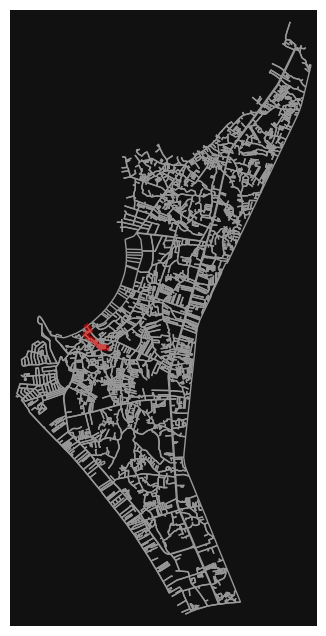

In [10]:
fig, ax = ox.plot_graph_route(G, route1, orig_dest_size=0, node_size=0)

In [11]:
# you can also pass any ox.plot_graph parameters as additional keyword args
fig, ax = ox.plot_graph_route(G, route1, save=True, show=False, close=True)

Or plot multiple routes with the `plot_graph_routes` function.

If you provide a list of route colors, each route will receive its own color.

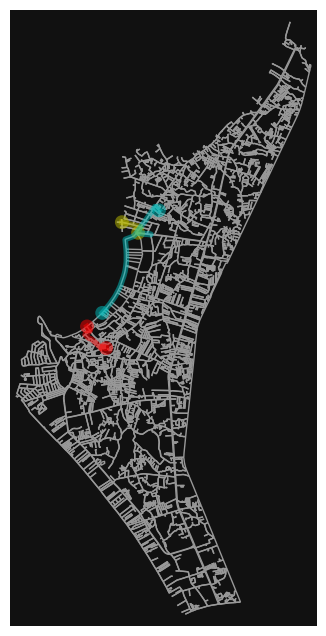

In [12]:
routes = [route1, route2, route3]
rc = ["r", "y", "c"]
fig, ax = ox.plot_graph_routes(G, routes, route_colors=rc, route_linewidth=6, node_size=0)

## Annotate a graph's plot

Here we label each street segment with its name. Similar logic would apply to labeling nodes instead.

In [13]:
G2 = ox.graph_from_address("Piedmont, CA, USA", dist=200, network_type="drive")
G2 = ox.get_undirected(G2)

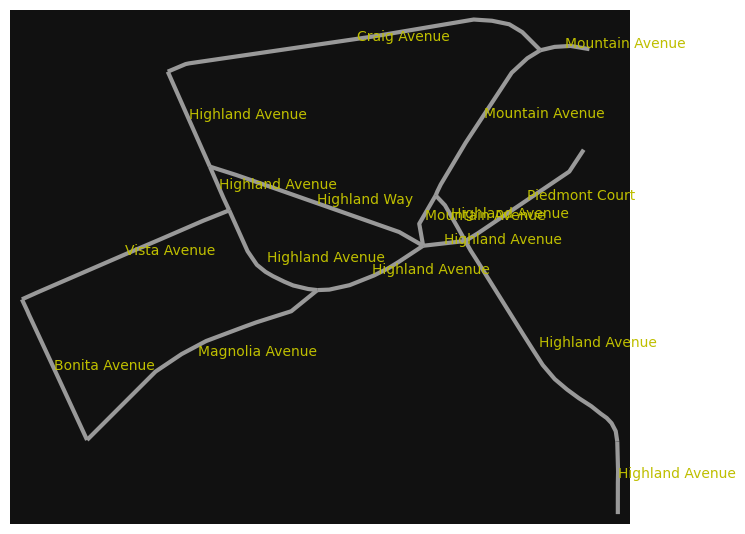

In [14]:
fig, ax = ox.plot_graph(G2, edge_linewidth=3, node_size=0, show=False, close=False)
for _, edge in ox.graph_to_gdfs(G2, nodes=False).fillna("").iterrows():
    text = edge["name"]
    c = edge["geometry"].centroid
    ax.annotate(text, (c.x, c.y), c="y")
plt.show()

## Plot footprints

The `plot_footprints` function lets you plot OSM geospatial features (Polygons and MultiPolygons).

In [19]:
# get all the building footprints in a city
gdf = ox.features_from_place("pattaya, chonburi", {"building": True})
gdf.shape

(11600, 181)

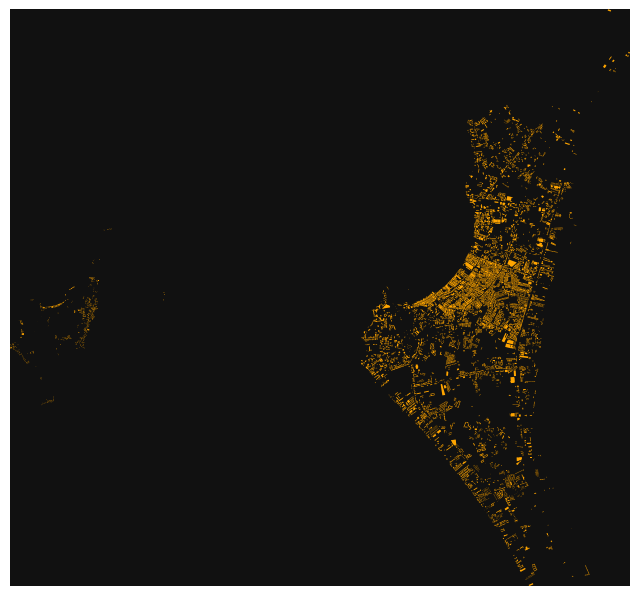

In [20]:
fig, ax = ox.plot_footprints(gdf)

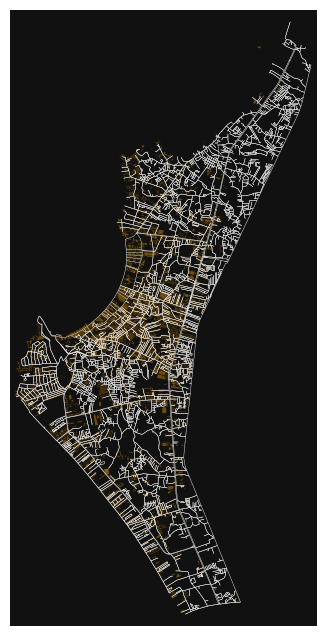

In [21]:
# or plot street network and the geospatial features' footprints together
fig, ax = ox.plot_footprints(gdf, alpha=0.4, show=False)
fig, ax = ox.plot_graph(G, ax=ax, node_size=0, edge_color="w", edge_linewidth=0.3)

In [3]:
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point
lat, lon = 12.9273342, 100.8987168
radius_meters = 500
# creata polygon from a lat-long point with a 1-mile radius in circle
point = Point((lon, lat))
circle = point.buffer(radius_meters)

gdf = gpd.GeoDataFrame({'geometry': [circle]})
# get polygon
polygon = gdf['geometry'].iloc[0]

In [39]:
# get lat lon from gdf
# lat = gdf["geometry"].centroid.y.iloc[0]
# lon = gdf["geometry"].centroid.x.iloc[0]
lat, lon = 12.9273342, 100.8987168
# lat, lon = 12.9273342, 100.8988
print(lat, lon) # 12.9273342 100.8987168
# get feature from square around lat lon and use features_from_polygon
# create buffer around point and get polygon bbox
buffer_dist = 500
bbox = ox.utils_geo.bbox_from_point((lat, lon), dist=buffer_dist)
# create a new buffer polygon from this bbox geometry
polygon = ox.utils_geo.bbox_to_poly(*bbox)

# create polygon from point 


# get features from polygon
gdf = ox.features_from_polygon(polygon, {"building": True})
G = ox.graph_from_polygon(polygon, network_type="drive")

12.9273342 100.8987168


In [40]:
print(polygon)

POLYGON ((100.89410326636063 12.922837598322536, 100.90333033363937 12.922837598322536, 100.90333033363937 12.931830801677465, 100.89410326636063 12.931830801677465, 100.89410326636063 12.922837598322536))


In [9]:
print(polygon)

POLYGON ((600.8987168 12.9273342, 598.4910801360985 -36.081235964780305, 591.2913570016152 -84.61782680806412, 579.3688846661045 -132.21500442723118, 562.8384830556433 -178.4143819825449, 541.8593489741776 -222.77103421299884, 516.6335229512727 -264.85778230980105, 487.40394348136846 -304.2693078818227, 454.45210739327376 -340.6260563932737, 418.09535888182273 -373.57789248136845, 378.6838333098011 -402.8074719512726, 336.59708521299893 -428.03329797417746, 292.2404329825449 -449.01243205564333, 246.04105542723119 -465.5428336661044, 198.44387780806417 -477.4653060016152, 149.90728696478038 -484.6650291360984, 100.89871680000003 -487.0726658, 51.89014663521968 -484.66502913609844, 3.3535557919359036 -477.4653060016152, -44.24362182723108 -465.54283366610446, -90.44299938254487 -449.01243205564333, -134.79965161299884 -428.0332979741775, -176.88639970980097 -402.80747195127265, -216.2979252818227 -373.5778924813685, -252.65467379327373 -340.62605639327376, -285.6065098813685 -304.269307

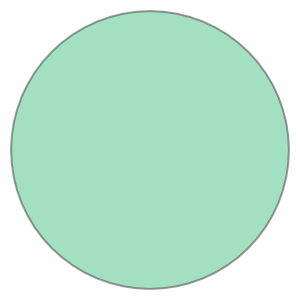

In [41]:

lat, lon = 12.9273342, 100.8987168

print(lat, lon) 
buffer_dist = 500

# creata polygon from a lat-long point with a 1-mile radius in circle
point = Point((lon, lat))
circle = point.buffer(buffer_dist)

# gdf = gpd.GeoDataFrame({'geometry': [circle]})
# # get polygon


# # Get the polygon from the GeoDataFrame
# polygon = gdf['geometry'].iloc[0]
# Get features (buildings) within the polygon
gdf = ox.features_from_point((lat,lon), tags={'building': True},dist=buffer_dist)

# Create a graph (network) from the polygon for the "drive" network type
G = ox.graph_from_point((lat,lon), dist=buffer_dist, network_type="drive")


12.9273342 100.8987168


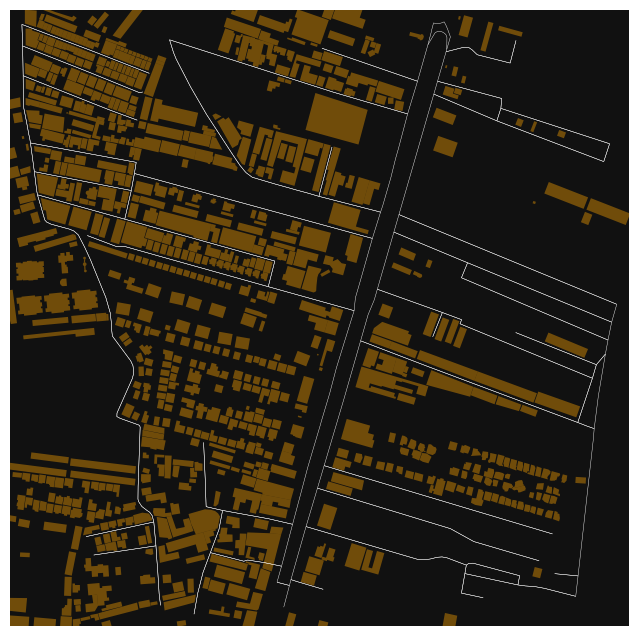

Figure size (in inches): [8. 8.]


In [44]:
fig, ax = ox.plot_footprints(gdf, alpha=0.4, show=False)
fig, ax = ox.plot_graph(G, ax=ax, node_size=0, edge_color="w", edge_linewidth=0.3,save=True, show=True, close=True, filepath="./image_1.png")

fig_size = fig.get_size_inches()

# Print the size
print("Figure size (in inches):", fig_size)

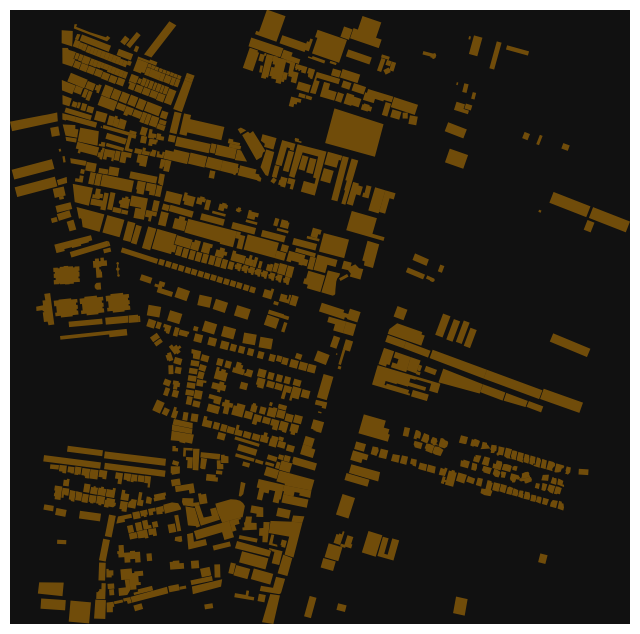

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

# Specify the center latitude and longitude of the circle
circle_lat = lat
circle_lon = lon

# Radius of the circle in meters (you can adjust this)
circle_radius_meters = 200

# Convert the radius from meters to degrees (approximately)
radius_degrees = (circle_radius_meters / 111300)  # 1 degree is approximately 111,300 meters

# Create a Matplotlib figure and axis
fig, ax = ox.plot_footprints(gdf, alpha=0.4, show=False)

# add road_wide to G

fig, ax = ox.plot_graph(G, ax=ax, node_size=0, edge_color="w", edge_linewidth=0.3, save=False, show=False)




# Set the aspect ratio to 'equal' to ensure the circle appears circular

# Save the plot to an image file
# fig.savefig("./image_1.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

# Close the figure to release resources
plt.close(fig)


In [64]:
gdf = ox.features_from_point((lat,lon),tags={"highway":True}, dist=buffer_dist)


In [67]:
gdf.explore()